In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\light\AppData\Local\Temp\ipykernel_53848\232652255.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
GAMES_CSV = "data/games.csv"
PLAYS_CSV = "data/plays.csv"
WEEK_GLOB = "data/week*.csv"

In [3]:
# importing train data
cb_wr_data = pd.read_csv("custom/CB_WR_data.csv")
cb_wr_data.drop("Unnamed: 0", axis=1, inplace=True)
cb_wr_data.head()

,gameId,playId,successOff,manCoverage,targetOff,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,...,ratMean,ratVar,heightAdv,route,WR,TE,RB,CB,FS,WRToCBRatio
0,2018090600,75,True,False,True,2555383,Jalen Mills,PHI,CB,2495454,...,0.692733,0.043521,-3.0,HITCH,2,1,1,2,2,1.000000
1,2018090600,146,False,False,False,2552689,Ronald Darby,PHI,CB,2557034,...,0.548798,0.013176,1.0,HITCH,3,1,1,3,1,1.000000
2,2018090600,146,False,False,False,2557958,Sidney Jones,PHI,CB,2552418,...,0.922523,0.233658,2.0,CROSS,3,1,1,3,1,1.000000
3,2018090600,146,False,False,True,2555383,Jalen Mills,PHI,CB,2560854,...,1.275015,0.015805,-1.0,HITCH,3,1,1,3,1,1.000000
4,2018090600,168,False,False,False,2552689,Ronald Darby,PHI,CB,2533040,...,0.890796,0.009496,-3.0,SLANT,2,1,2,3,1,0.666667


In [9]:
games = pd.read_csv(GAMES_CSV)
plays = pd.read_csv(PLAYS_CSV)

In [27]:
def find_first_move_frame(track_df, by, val, angle_deg_thresh=2.0, min_speed=0.0):
    """
    Find the first frame where the highlighted WR changes heading by >= angle_deg_thresh
    while moving at >= min_speed. Returns (frameId, x, y) or (None, None, None).
    Heading from successive positions; angle diff is unwrapped for robustness.
    """

    # Restrict tracking data to frames after the ball snap (plus 3)
    snap_rows = track_df.loc[track_df["event"].astype(str).str.lower() == "ball_snap"]
    snap_frame = int(pd.to_numeric(snap_rows["frameId"], errors="coerce").min())
    track_df = track_df[pd.to_numeric(track_df["frameId"], errors="coerce") >= (snap_frame + 3)].copy()
    #print(f"Tracking data filtered: kept {len(track_df)} rows after ball_snap (starting at frame {snap_frame + 3})")

    # Restrict tracking data to frames before the pass_forward
    before_pass_rows = track_df.loc[track_df["event"].astype(str).str.lower() == "pass_forward"]
    if before_pass_rows.empty:
        return (None, None, None)
    before_pass_frame = int(pd.to_numeric(before_pass_rows["frameId"], errors="coerce").min())
    track_df = track_df[pd.to_numeric(track_df["frameId"], errors="coerce") < before_pass_frame].copy()
    #print(f"Tracking data filtered: kept {len(track_df)} rows before pass_forward (up to frame {before_pass_frame + 3})")

    wr = track_df[track_df[by] == val].dropna(subset=["frameId", "x", "y"]).copy()
    wr = wr.sort_values("frameId")

    dir_eff = wr["dir"].values
    spd_eff = wr["s"].values

    n = len(dir_eff)

    frames = wr["frameId"].values
    
    xs = wr["x"].values
    ys = wr["y"].values

    idx = None
    for i in range(1,n):
        if (np.abs(dir_eff[i] - dir_eff[i-1]) >= angle_deg_thresh) and (spd_eff[i] >= min_speed):
            idx = i   
            break

    if idx is None:
        return (None, None, None)

    return (int(frames[idx]), float(xs[idx]), float(ys[idx]))

In [28]:
# 1) Before the loop: add the feature column, default 0
cb_wr_data["Move Separation"] = 0.0

four_tuple = cb_wr_data[['gameId', 'playId', 'nflIdDef', 'nflIdOff']].values
for i in range(len(four_tuple)):  # <- use all rows
    if i% 100 == 0:
        print(f"Processing row {i+1} of {len(four_tuple)}")
    GAME_ID, PLAY_ID, CB_ID, WR_ID = four_tuple[i]
    HIGHLIGHT_WR_BY = "nflId"
    HIGHLIGHT_WR_VAL = WR_ID
    HIGHLIGHT_CB_BY = "nflId"
    HIGHLIGHT_CB_VAL = CB_ID

    ANGLE_THRESHOLD_DEG = 7.5
    MIN_SPEED_YDPS = 1.5

    game_row = games.loc[games["gameId"] == GAME_ID].iloc[0]
    actual_week = int(game_row["week"])
    week_file_needed = f"data/week{actual_week}.csv"
    tracking = pd.read_csv(week_file_needed)
    track = tracking[
        (pd.to_numeric(tracking["gameId"], errors="coerce") == GAME_ID) &
        (pd.to_numeric(tracking["playId"], errors="coerce") == PLAY_ID)
    ].copy()

    for c in ["gameId","playId","frameId"]:
        track[c] = pd.to_numeric(track[c], errors="coerce")

    need_cols = ["x","y","s","dir","event","displayName","jerseyNumber","frameId","team","nflId"]
    track = track[[c for c in need_cols if c in track.columns]].copy()

    rad = np.deg2rad(pd.to_numeric(track["dir"], errors="coerce"))
    speed = pd.to_numeric(track["s"], errors="coerce").fillna(0.0)
    track["v_x"] = np.sin(rad) * speed
    track["v_y"] = np.cos(rad) * speed

    for col in {HIGHLIGHT_WR_BY, HIGHLIGHT_CB_BY} - {None}:
        if col in track.columns:
            if col in ["nflId", "jerseyNumber", "frameId"]:
                track[col] = pd.to_numeric(track[col], errors="coerce")
            else:
                track[col] = track[col].astype(str)

    move_frame_id, move_x, move_y = find_first_move_frame(
        track, HIGHLIGHT_WR_BY, HIGHLIGHT_WR_VAL,
        angle_deg_thresh=ANGLE_THRESHOLD_DEG,
        min_speed=MIN_SPEED_YDPS
    )

    # --- separation feature (mean at -3 vs +3 frames) ---
    sep_created = 0.0  # default if no move or data missing
    if move_frame_id is not None and np.isfinite(move_frame_id):
        wr_pos = track.loc[track["nflId"] == WR_ID, ["frameId", "x", "y"]].rename(
            columns={"x": "x_wr", "y": "y_wr"}
        )
        cb_pos = track.loc[track["nflId"] == CB_ID, ["frameId", "x", "y"]].rename(
            columns={"x": "x_cb", "y": "y_cb"}
        )
        pairs = (
            wr_pos.merge(cb_pos, on="frameId", how="inner")
                  .dropna(subset=["x_wr","y_wr","x_cb","y_cb"])
        )

        # Choose single frames 3 before / 3 after (skip move frame)
        before_frame = move_frame_id - 3
        after_frame  = move_frame_id + 3

        def _sep_at(frame_id):
            sub = pairs[pairs["frameId"] == frame_id]
            if sub.empty:
                return np.nan
            d = np.hypot(
                sub["x_wr"].to_numpy() - sub["x_cb"].to_numpy(),
                sub["y_wr"].to_numpy() - sub["y_cb"].to_numpy()
            )
            return float(np.nanmean(d)) if d.size else np.nan

        before_mean = _sep_at(before_frame)
        after_mean  = _sep_at(after_frame)

        if np.isfinite(before_mean) and np.isfinite(after_mean):
            sep_created = after_mean - before_mean
        else:
            sep_created = 0.0  # fallback if either side missing

    # 2) Write to the new feature column for this row
    cb_wr_data.loc[cb_wr_data.index[i], "Move Separation"] = float(sep_created)


Processing row 1 of 2408
Processing row 101 of 2408
Processing row 201 of 2408
Processing row 301 of 2408
Processing row 401 of 2408
Processing row 501 of 2408
Processing row 601 of 2408
Processing row 701 of 2408
Processing row 801 of 2408
Processing row 901 of 2408
Processing row 1001 of 2408
Processing row 1101 of 2408
Processing row 1201 of 2408
Processing row 1301 of 2408
Processing row 1401 of 2408
Processing row 1501 of 2408
Processing row 1601 of 2408
Processing row 1701 of 2408
Processing row 1801 of 2408
Processing row 1901 of 2408
Processing row 2001 of 2408
Processing row 2101 of 2408
Processing row 2201 of 2408
Processing row 2301 of 2408
Processing row 2401 of 2408


In [31]:
cb_wr_data.to_csv("custom/CB_WR_data_with_move_separation_full.csv")

In [20]:
four_tuple = cb_wr_data[['gameId', 'playId', 'nflIdDef', 'nflIdOff']].values
for i in range(1):#len(four_tuple)):
    play = four_tuple[i]
    GAME_ID, PLAY_ID, CB_ID, WR_ID = play
    HIGHLIGHT_WR_BY = "nflId"
    HIGHLIGHT_WR_VAL = WR_ID

    HIGHLIGHT_CB_BY = "nflId"
    HIGHLIGHT_CB_VAL = CB_ID

    ANGLE_THRESHOLD_DEG = 7.5 # minimum change in heading (deg) to count as a "move"
    MIN_SPEED_YDPS = 1.5


    game_row = games.loc[games["gameId"] == GAME_ID]
    game_row = game_row.iloc[0]
    actual_week = int(game_row["week"])
    week_file_needed = f"data/week{actual_week}.csv"
    tracking = pd.read_csv(week_file_needed)
    selected_week = week_file_needed
    track = tracking[(pd.to_numeric(tracking["gameId"], errors="coerce") == GAME_ID) &
                 (pd.to_numeric(tracking["playId"], errors="coerce") == PLAY_ID)].copy()
    required_cols = {"gameId","playId","frameId","x","y","team","s","dir"}
    for c in ["gameId","playId","frameId"]:
        track[c] = pd.to_numeric(track[c], errors="coerce")
    frame_ids = track["frameId"].dropna().astype(int).sort_values().unique().tolist()
    print(f"Frames found: {len(frame_ids)}  (first={frame_ids[0]}, last={frame_ids[-1]})")

    need_cols = ["x","y","s","dir","event","displayName","jerseyNumber","frameId","team","nflId"]
    track = track[[c for c in need_cols if c in track.columns]].copy()
    rad = np.deg2rad(pd.to_numeric(track["dir"], errors="coerce"))
    speed = pd.to_numeric(track["s"], errors="coerce").fillna(0.0)
    track["v_x"] = np.sin(rad) * speed
    track["v_y"] = np.cos(rad) * speed


    for col in {HIGHLIGHT_WR_BY, HIGHLIGHT_CB_BY} - {None}:
        if col and col in track.columns:
            if col in ["nflId", "jerseyNumber", "frameId"]:
                track[col] = pd.to_numeric(track[col], errors="coerce")
            else:
                track[col] = track[col].astype(str)

    move_frame_id, move_x, move_y = find_first_move_frame(
            track, HIGHLIGHT_WR_BY, HIGHLIGHT_WR_VAL,
            angle_deg_thresh=ANGLE_THRESHOLD_DEG,
            min_speed=MIN_SPEED_YDPS
    )
    print("WR move detected at frame:", move_frame_id)




        # --- separation: mean of 2 frames before vs 2 frames after the move ---
    sep_created = np.nan
    before_mean = np.nan
    after_mean = np.nan

    if move_frame_id is not None and np.isfinite(move_frame_id):
        # Build WR/CB per-frame positions once
        wr_pos = track.loc[track["nflId"] == WR_ID, ["frameId", "x", "y"]].rename(
            columns={"x": "x_wr", "y": "y_wr"}
        )
        cb_pos = track.loc[track["nflId"] == CB_ID, ["frameId", "x", "y"]].rename(
            columns={"x": "x_cb", "y": "y_cb"}
        )
        pairs = (
            wr_pos.merge(cb_pos, on="frameId", how="inner")
                .dropna(subset=["x_wr","y_wr","x_cb","y_cb"])
        )
        # frames to use (exclude the move frame itself)
        before_frames = [move_frame_id - 3]
        after_frames  = [move_frame_id + 3]

        def _mean_sep(frames):
            sub = pairs[pairs["frameId"].isin(frames)]
            if sub.empty: 
                return np.nan
            d = np.hypot(sub["x_wr"].to_numpy() - sub["x_cb"].to_numpy(),
                        sub["y_wr"].to_numpy() - sub["y_cb"].to_numpy())
            return float(np.nanmean(d)) if d.size else np.nan

        before_mean = _mean_sep(before_frames)
        after_mean  = _mean_sep(after_frames)
        sep_created = after_mean - before_mean

    print("Separation (mean, 2 frames before):", before_mean)
    print("Separation (mean, 2 frames after):",  after_mean)
    print("Separation created (after - before):", sep_created)

        

Frames found: 59  (first=1, last=59)
Tracking data filtered: kept 644 rows after ball_snap (starting at frame 14)
Tracking data filtered: kept 308 rows before pass_forward (up to frame 39)
WR move detected at frame: 35
Separation (mean, 2 frames before): 3.862188498765952
Separation (mean, 2 frames after): 4.623126647627114
Separation created (after - before): 0.760938148861162


In [6]:
# Helper functions
def slice_cols(df, start_col, end_col):
    return df.loc[:, start_col:end_col]

In [7]:
# Clean the data set to be from nframes to WRToCBRatio
coverage_data = pd.concat([cb_wr_data[["manCoverage"]],slice_cols(cb_wr_data, "nFrames", "WRToCBRatio"),],axis=1).copy()
coverage_data.drop(columns=["heightAdv"], inplace=True)
coverage_data["manCoverage"] = (coverage_data["manCoverage"] == True).astype(int)                      

In [8]:
from sklearn.calibration import LabelEncoder
if "route" in coverage_data.columns:
    le = LabelEncoder()
    coverage_data["route"] = le.fit_transform(coverage_data["route"].astype(str))
    print("Route encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Route encoding mapping: {'ANGLE': 0, 'CORNER': 1, 'CROSS': 2, 'FLAT': 3, 'GO': 4, 'HITCH': 5, 'IN': 6, 'OUT': 7, 'POST': 8, 'SCREEN': 9, 'SLANT': 10, 'nan': 11}


In [9]:
# Train-test split
X = coverage_data.drop(columns=["manCoverage"])
y = coverage_data["manCoverage"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, shuffle=True, stratify=y)
X.head()

,nFrames,xVar,yVar,sVar,sMax,dxVar,dyVar,xLOS,maxDepth,endDepth,...,lookingAtQBVar,ratMean,ratVar,route,WR,TE,RB,CB,FS,WRToCBRatio
0,35,4.826532,0.220460,4.683821,5.34,0.045451,0.002066,30,9.00,9.00,...,0.196639,0.692733,0.043521,5,2,1,1,2,2,1.000000
1,30,1.048582,0.023507,1.578681,3.48,0.016704,0.000749,71,5.89,5.89,...,0.000000,0.548798,0.013176,5,3,1,1,3,1,1.000000
2,30,0.075213,0.646736,0.906794,3.60,0.002467,0.040579,71,2.78,2.78,...,0.143678,0.922523,0.233658,2,3,1,1,3,1,1.000000
3,30,0.176702,0.063348,0.565127,3.03,0.005859,0.003850,71,3.23,3.23,...,0.000000,1.275015,0.015805,5,3,1,1,3,1,1.000000
4,33,1.509110,0.000737,1.315740,2.74,0.012607,0.000182,71,5.37,5.37,...,0.132576,0.890796,0.009496,10,2,1,2,3,1,0.666667


In [10]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_train.columns))
dtest  = xgb.DMatrix(X_test, label=y_test, feature_names=list(X_test.columns))
watchlist = [(dtrain, "train"), (dtest, "test")]

In [11]:
# Experiment

params_basic = {
    "eta": 0.1,
    "max_depth": 5,
    "colsample_bytree": 0.5,
    "objective": "binary:logistic",
    "eval_metric": "error",
}

basic_boost = xgb.train(
    params=params_basic,
    dtrain=dtrain,
    num_boost_round=20,
    evals=watchlist,
    verbose_eval=False,
)

pred_basic_prob = basic_boost.predict(dtest)
pred_basic = (pred_basic_prob > 0.5).astype(int)

print("\n=== Basic XGBoost: Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, pred_basic))
print(confusion_matrix(y_test, pred_basic))


=== Basic XGBoost: Test Metrics ===
Accuracy: 0.7572614107883817
[[272  36]
 [ 81  93]]


C:\Users\light\AppData\Local\Temp\ipykernel_35508\2527646961.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


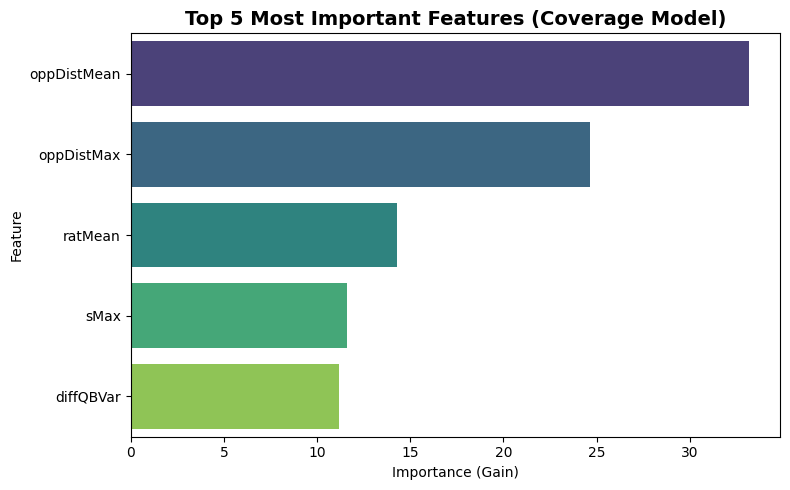

In [12]:
importance_dict = basic_boost.get_score(importance_type="gain")

# Convert to DataFrame
importance_df = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})

# Sort and keep top 5
top5 = importance_df.sort_values("importance", ascending=False).head(5)

# --- Pretty Plot ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=top5,
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Top 5 Most Important Features (Coverage Model)", fontsize=14, weight="bold")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [13]:
"""
# Get predicted probabilities and threshold at 0.5
y_pred_prob = basic_boost.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Labels for coverage classes
labels = ["Zone", "Man"]

# Pretty heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.title("Coverage Model — Basic Boost Confusion Matrix", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()
"""

'\n# Get predicted probabilities and threshold at 0.5\ny_pred_prob = basic_boost.predict(dtest)\ny_pred = (y_pred_prob > 0.5).astype(int)\n\n# Compute confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Labels for coverage classes\nlabels = ["Zone", "Man"]\n\n# Pretty heatmap\nplt.figure(figsize=(6,5))\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues",\n            xticklabels=labels, yticklabels=labels, cbar=False)\n\nplt.title("Coverage Model — Basic Boost Confusion Matrix", fontsize=14, weight="bold")\nplt.xlabel("Predicted Label", fontsize=12)\nplt.ylabel("True Label", fontsize=12)\nplt.show()\n'

In [14]:
full_cb_wr_data = pd.read_csv("custom/full_cb_wr_data.csv").copy()
full_cb_wr_data.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,isTarget,epa,defenseWin,offenseWin,heightDef,nflId,height,displayName,heightOff,heightAdv
0,2018090600,75,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,True,0.261827,False,True,74,2495454,74,Julio Jones,74,0
1,2018090600,146,1,2552689,Ronald Darby,PHI,CB,2557034,Marvin Hall,ATL,...,False,-0.372360,True,False,74,2557034,74,Marvin Hall,74,0
2,2018090600,146,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,True,-0.372360,True,False,74,2560854,74,Calvin Ridley,74,0
3,2018090600,146,1,2557958,Sidney Jones,PHI,CB,2552418,Justin Hardy,ATL,...,False,-0.372360,True,False,74,2552418,74,Justin Hardy,74,0
4,2018090600,168,1,2552689,Ronald Darby,PHI,CB,2533040,Mohamed Sanu,ATL,...,False,-0.702779,True,False,74,2533040,74,Mohamed Sanu,74,0


In [15]:
full_coverage_data = pd.concat(
    [
        full_cb_wr_data[["manCoverage"]],
        slice_cols(full_cb_wr_data, "nFrames", "WRToCBRatio"),
    ],
    axis=1
)
full_coverage_data.head()

,manCoverage,nFrames,xVar,yVar,sVar,sMax,dxVar,dyVar,xLOS,maxDepth,...,lookingAtQBVar,ratMean,ratVar,route,WR,TE,RB,CB,FS,WRToCBRatio
0,False,35,4.826532,0.220460,4.683821,5.34,0.045451,0.002066,30,9.00,...,0.196639,0.692733,0.043521,HITCH,2,1,1,2,2,1.000000
1,False,30,1.048582,0.023507,1.578681,3.48,0.016704,0.000749,71,5.89,...,0.000000,0.548798,0.013176,HITCH,3,1,1,3,1,1.000000
2,False,30,0.176702,0.063348,0.565127,3.03,0.005859,0.003850,71,3.23,...,0.000000,1.275015,0.015805,HITCH,3,1,1,3,1,1.000000
3,False,30,0.075213,0.646736,0.906794,3.60,0.002467,0.040579,71,2.78,...,0.143678,0.922523,0.233658,CROSS,3,1,1,3,1,1.000000
4,False,33,1.509110,0.000737,1.315740,2.74,0.012607,0.000182,71,5.37,...,0.132576,0.890796,0.009496,SLANT,2,1,2,3,1,0.666667


In [16]:
if "route" in full_coverage_data.columns:
    full_coverage_data["route"] = full_coverage_data["route"].map(
        lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else -1
    )

In [17]:
X_full = full_coverage_data.drop(columns=["manCoverage"])
dfull_big = xgb.DMatrix(X_full.values,feature_names=list(X_full.columns))

In [18]:
pred_full_basic = basic_boost.predict(dfull_big)
full_cb_wr_data = full_cb_wr_data.copy()
full_cb_wr_data["pred_man"] = pred_full_basic
prop_over_03_basic = (full_cb_wr_data["pred_man"] > 0.3).mean()
print("\nProportion of full routes with pred_man > 0.3 (basic):", prop_over_03_basic)


Proportion of full routes with pred_man > 0.3 (basic): 0.48926735643848307


In [19]:
random.seed(2025)
np.random.seed(2025)

def sample_params():
    return {
        "booster": "gbtree",
        "objective": "binary:logistic",
        "max_depth": int(np.random.choice(np.arange(3, 11))),
        "eta": float(np.random.uniform(0.01, 0.3)),
        "subsample": float(np.random.uniform(0.7, 1.0)),
        "colsample_bytree": float(np.random.uniform(0.6, 1.0)),
        "eval_metric": "error",
    }

param_list = [sample_params() for _ in range(1000)]
parameters_df = pd.DataFrame(param_list)

In [20]:
lowest_error_list = []


for i, p in parameters_df.iterrows():
    bst = xgb.train(
        params=p.to_dict(),
        dtrain=dtrain,
        num_boost_round=300,
        evals=[(dtrain, "train"), (dtest, "val")],
        early_stopping_rounds=30,
        verbose_eval=False,
    )
    best_val_error = bst.best_score  
    lowest_error_list.append(1.0 - best_val_error)

randomsearch = parameters_df.copy()
randomsearch.insert(0, "val_acc", lowest_error_list)
randomsearch = randomsearch.sort_values("val_acc", ascending=False).reset_index(drop=True)

print("\n=== Random Search ===")
print("Best validation accuracy:", randomsearch.loc[0, "val_acc"])




=== Random Search ===
Best validation accuracy: 0.8070539419087137


In [21]:
best = randomsearch.iloc[0].to_dict()
params_tuned = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "max_depth": int(best["max_depth"]),
    "eta": float(best["eta"]),
    "subsample": float(best["subsample"]),
    "colsample_bytree": float(best["colsample_bytree"]),
    "eval_metric": "error",
}

xgb_tune = xgb.train(
    params=params_tuned,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=30,
    verbose_eval=False,
)

In [22]:
pred_tune_test_prob = xgb_tune.predict(dtest)
pred_tune_test = (pred_tune_test_prob > 0.5).astype(int)

print("\n=== Tuned XGBoost: Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, pred_tune_test))
print(confusion_matrix(y_test, pred_tune_test))
print(classification_report(y_test, pred_tune_test, digits=4))

pred_tune_train_prob = xgb_tune.predict(dtrain)
pred_tune_train = (pred_tune_train_prob > 0.5).astype(int)

print("\n=== Tuned XGBoost: Train Metrics ===")
print("Accuracy:", accuracy_score(y_train, pred_tune_train))
print(confusion_matrix(y_train, pred_tune_train))
print(classification_report(y_train, pred_tune_train, digits=4))




=== Tuned XGBoost: Test Metrics ===
Accuracy: 0.7800829875518672
[[265  43]
 [ 63 111]]
              precision    recall  f1-score   support

           0     0.8079    0.8604    0.8333       308
           1     0.7208    0.6379    0.6768       174

    accuracy                         0.7801       482
   macro avg     0.7644    0.7492    0.7551       482
weighted avg     0.7765    0.7801    0.7768       482


=== Tuned XGBoost: Train Metrics ===
Accuracy: 0.9994807892004154
[[1233    0]
 [   1  692]]
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996      1233
           1     1.0000    0.9986    0.9993       693

    accuracy                         0.9995      1926
   macro avg     0.9996    0.9993    0.9994      1926
weighted avg     0.9995    0.9995    0.9995      1926



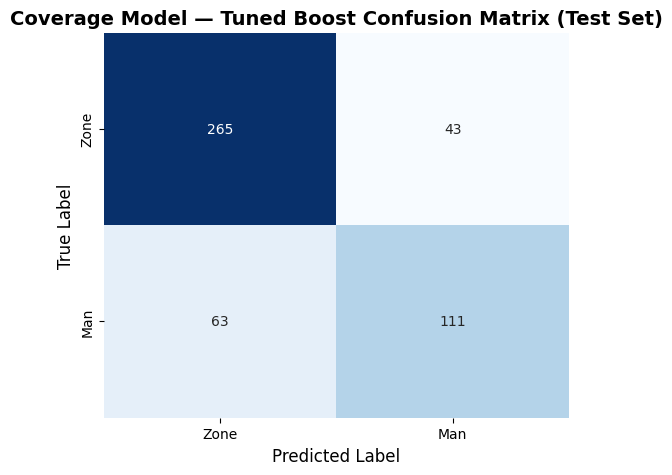

In [23]:
y_pred_prob_tuned = xgb_tune.predict(dtest)
y_pred_tuned = (y_pred_prob_tuned > 0.5).astype(int)

# Confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# Labels
labels = ["Zone", "Man"]

# Pretty heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.title("Coverage Model — Tuned Boost Confusion Matrix (Test Set)", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

In [24]:
cv_results = xgb.cv(
    params=params_tuned,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=10,
    metrics=("error",),
    early_stopping_rounds=30,
    verbose_eval=False,
    seed=2025,
)
print("\n=== 10-fold CV (tuned params) ===")
print(cv_results.tail(1))


pred_full_tuned = xgb_tune.predict(dfull_big)
full_cb_wr_data_tuned = full_cb_wr_data.copy()
full_cb_wr_data_tuned["pred_man"] = pred_full_tuned

prop_over_03_tuned = (full_cb_wr_data_tuned["pred_man"] > 0.3).mean()
print("\nProportion of full routes with pred_man > 0.3 (tuned):", prop_over_03_tuned)

full_cb_wr_data_tuned.to_csv("predictions/full_cb_wr_data_preds.csv", index=False)


=== 10-fold CV (tuned params) ===
    train-error-mean  train-error-std  test-error-mean  test-error-std
52          0.003115         0.001006         0.237786         0.02776

Proportion of full routes with pred_man > 0.3 (tuned): 0.4194886275894019


be less aggresive with the tree construction

memorize the tree space 